# İnme-Felç Geçirme Tahmini

#### Öğrenci İsimleri : Mehmet Sezer,Burak Yılmaz



## İçerik

[Problem](#Problem)   
[Verinin Anlaşılması](#Verilerin_Anlaşılması)       
[Veriyi Görselleştirme](#Veriyi_Görselleştirme)   
[Verilerin Hazırlanması](#Verilerin_Hazırlanması)  
[Modelleme](#modelleme)  
[Değerlendirme](#Değerlendirme)  
[Referanslar](#Referanslar)   


## Problem <a class="anchor" id="purpose"></a>

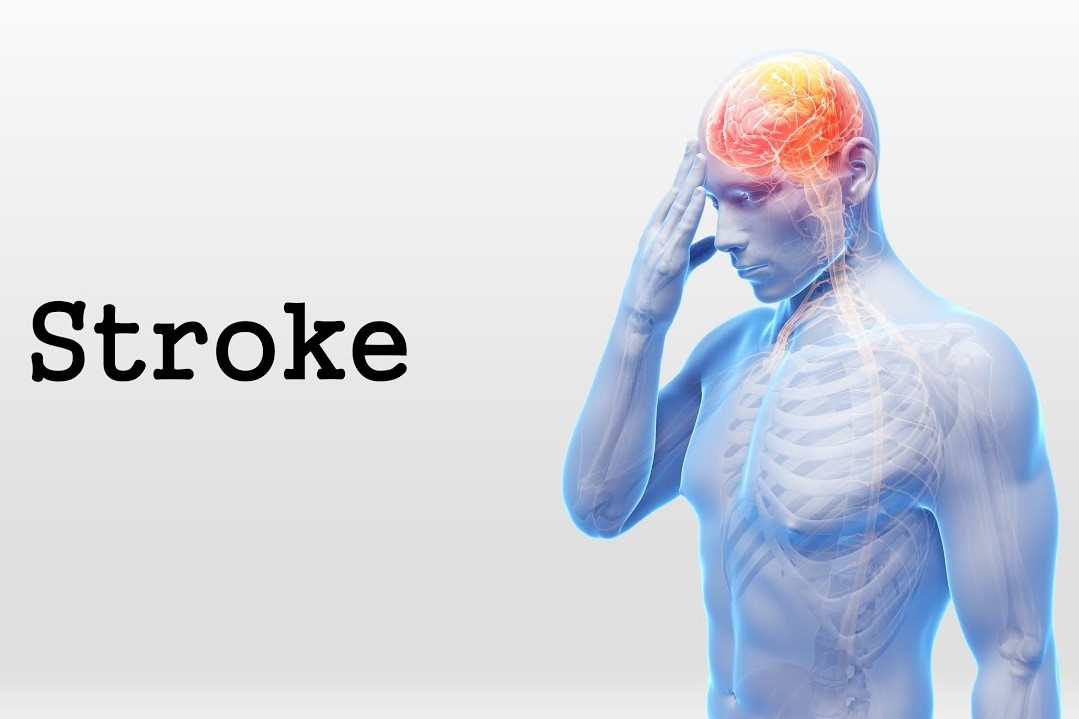
Önce inme nedir ile başlayalım?

İnme, beyne zayıf kan akışının hücre ölümüne neden olduğu tıbbi bir durumdur. İki ana felç türü vardır. Bunlardan ilki kan akışının olmaması nedeniyle iskemik ve diğeri kanamaya bağlı hemorajik. Her ikisi de beynin bazı bölümlerinin düzgün çalışmamasına neden olur. Bir inmenin belirti ve semptomları, vücudun bir tarafında hareket edememe veya hissetmeme, anlama veya konuşma problemleri, baş dönmesi veya bir tarafa görme kaybı olabilir. Belirtiler ve semptomlar genellikle felç meydana geldikten hemen sonra ortaya çıkar. Semptomlar bir veya iki saatten az sürerse, inme, mini inme olarak da adlandırılan geçici bir iskemik ataktır (TIA). Hemorajik inme ayrıca şiddetli bir baş ağrısıyla ilişkilendirilebilir. İnmenin semptomları kalıcı olabilir. Uzun vadeli komplikasyonlar arasında pnömoni ve mesane kontrolünün kaybı olabilir.

Dünya Sağlık Örgütü'ne (WHO) göre inme, küresel olarak 2. önde gelen ölüm nedenidir ve toplam ölümlerin yaklaşık% 11'inden sorumludur.Bu veri seti, cinsiyet gibi girdi parametrelerine göre bir hastanın felç geçirme olasılığının olup olmadığını tahmin etmek için kullanılır. yaş, çeşitli hastalıklar ve sigara içme durumu. Verilerdeki her satır, hasta hakkında ilgili bilgileri sağlar.

## Verinin Anlaşılması<a class="anchor" id="data_understanding"></a>

Gerekli kütüphaneleri eklemek.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import plotly.graph_objs as go
import pylab as pl
from plotly.subplots import make_subplots
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split,GridSearchCV
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,plot_roc_curve,roc_auc_score,roc_curve, auc
from imblearn.over_sampling import SMOTE

**Veri Hakkında Bilgiler**

Veri, kalp hastalığı olan hastalarla ilgili verileri ve aşağıdakileri belirleyen çeşitli nitelikleri içerir:

**id**: Benzersiz tanımlayıcı

**gender**: Cinsiyet

**age**: Yaş

**hypertension**: Hastada hipertansiyon yoksa 0, hastanın hipertansiyonu varsa 1

**heart_disease**: Hastada kalp hastalığı yoksa 0, hastada kalp hastalığı varsa 1

**ever_married**: Hiç evlenmiş mi?

**work_type**: Kişinin çalışma tipi

**Residence_type**: Konut tipi kırsal ya da kentsel

**avg_glucose_level**: Kandaki ortalama glikoz seviyesi

**bmi**: Vücut kitle indeksi

**smoking_status**: Sigara içme durumu

**stroke**: Hasta inme geçirdiyse 1 geçirmediyse 0

**Not: Smoking_status'taki "Unknown", bilgilerin bu hasta için mevcut olmadığı anlamına gelir**

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Makine öğrenimi modeliyle alakası olmadığı için "id" benzersiz tanımlayıcı sütununu kaldırıyoruz.

In [ ]:
df = df.drop('id', axis=1)

Tanımlayıcı istatistik bilgileri. Verilerimiz karma veri türlerinden oluştuğundan, varsayılan değer yalnızca sayısal sütunların bir analizini döndürmektir.

In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Veri seti, her biri farklı hastayı temsil eden 5110 satır ve farklı özellikler olan 11 sütundan oluşur.

In [ ]:
print("Toplam satır            :", df.shape[0])
print("Toplam sütun            :", df.shape[1])
print("Sütun isimleri          : ",end="")
for col in df.columns:
    print(col,end="\n\t\t          ")


Toplam satır            : 5110
Toplam sütun            : 11
Sütun isimleri          : gender
		          age
		          hypertension
		          heart_disease
		          ever_married
		          work_type
		          Residence_type
		          avg_glucose_level
		          bmi
		          smoking_status
		          stroke
		          

Veri setimizin bazı sütunlar için herhangi bir boş değer içerip içermediğine bakalım. Bmi sütununda daha sonra ele alacağımız 201 boş değer var.

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Veriyi Görselleştirme<a class="anchor" id="data_visualization"></a>

Önce veri setimizin sayısal özelliklerini inceleyeceğiz ve ardından kategori özellikleriyle devam edeceğiz.

Aşağıdaki grafiklere bakarak şunu söyleyebiliriz:

**Age** sütunu normal dağılımla dağılmıştır.

**Bmi** sütununda anormal değerler olabilir ve değerlerin çoğu 15-55 arasında toplanmış durumdadır. anormal değerler, dağılım eğrisinin sağa doğru oldukça eğimli olmasını sağlar.

**Avg glucose level** dağılım yarı normal dağılıma benziyor ve verilerin çoğu 150'nin altında, üstelik bmi alanı gibi anormal değerlere sahip.

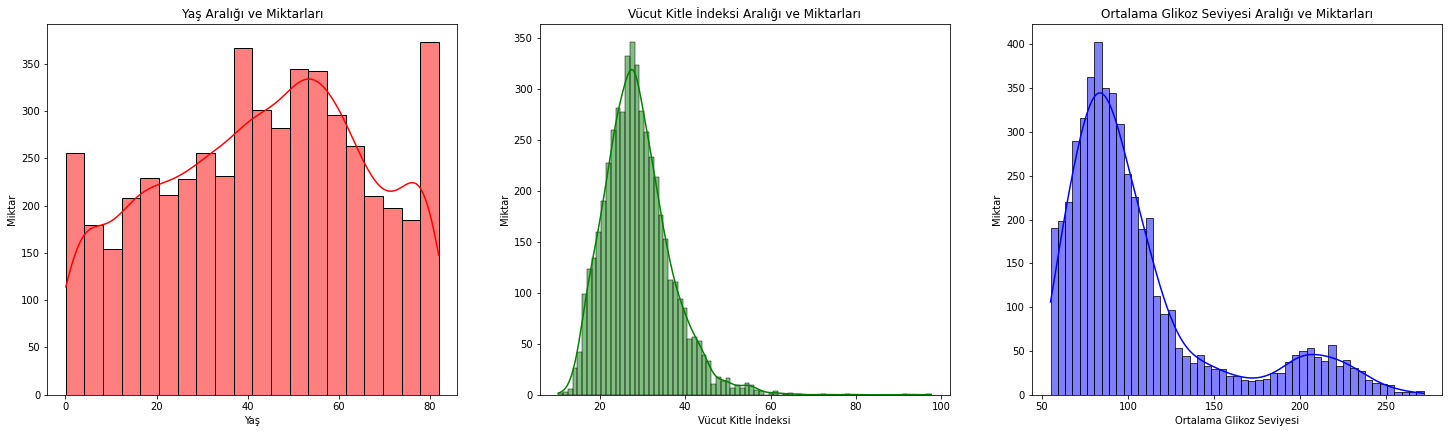

In [ ]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
ax = sns.histplot(df['age'], color = 'red', kde = True)
ax.set_title('Yaş Aralığı ve Miktarları')
ax.set(xlabel='Yaş', ylabel='Miktar')

plt.subplot(2,3,2)
ax2 = sns.histplot(df['bmi'], color = 'green', kde = True)
ax2.set_title('Vücut Kitle İndeksi Aralığı ve Miktarları')
ax2.set(xlabel='Vücut Kitle İndeksi', ylabel='Miktar')

plt.subplot(2,3,3)
ax3 = sns.histplot(df['avg_glucose_level'], kde = True, color = 'blue')
ax3.set_title('Ortalama Glikoz Seviyesi Aralığı ve Miktarları')
ax3.set(xlabel='Ortalama Glikoz Seviyesi', ylabel='Miktar');

Aşağıda kategorik özellikleri inceliyoruz ve bunların inme pozitif vakaları etkileyip etkilemediğini anlamaya çalışıyoruz.

Veri setimizdeki hastalar çoğunlukla hipertansiyona sahip değildir. Hipertansiyonu olan kişilerin dağılımı, hipertansiyonu olmayanların oranından önemli ölçüde daha yüksek olduğu için, inmenin hipertansiyonla oldukça ilişkili olduğunu söyleyebiliriz.

In [ ]:
value=df.hypertension.value_counts()
y1=df.query('stroke==0')['hypertension'].value_counts()
y2=df.query('stroke==1')['hypertension'].value_counts()
x=["yok", "var"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Hipertansiyon",'Hipertansiyon vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels=x,values=value , name="Hypertension",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=440, width=1300)
fig.show()

Veri setimizdeki hastaların çoğunlukla kalp hastalığı yoktur. Kalp hastalığı olan kişilerin proporitonu, kalp hastalığı olmayanların oranından önemli ölçüde daha yüksek olduğu için, inmenin kalp hastalığı ile oldukça ilişkili olduğunu söyleyebiliriz.

In [ ]:
value=df.heart_disease.value_counts()
y1=df.query('stroke==0')['heart_disease'].value_counts()
y2=df.query('stroke==1')['heart_disease'].value_counts()
x=["yok", "var"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Kalp Hastalığı",'Kalp Hastalığı vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels=x,values=value , name="Heart_Disease",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=520, width=1300)
fig.show()

Aşağıdaki grafik, inme pozitif olanların sigara içenler ile ilişkili olmadığını göstermektedir, çünkü inmeli kişilerin oranı diğer sigara içme durumları arasında hemen hemen aynıdır.

In [ ]:
value=df.smoking_status.value_counts()
y1=df.query('stroke==0')['smoking_status'].value_counts()
y2=df.query('stroke==1')['smoking_status'].value_counts()
x=["Hiç Kullanmamış", "Bilinmiyor","Eski Kullanıcı","Düzenli Kullanıcı"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Sigara İçme Durumu",'Sigara İçme Durumu vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels=x,values=value , name="Smoking Status",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=475, width=1300)
fig.show()

Aşağıdaki grafiklerden katılımcıların neredeyse yarısının özel bir işi olduğunu söyleyebiliriz. İnme pozitif olanların oranı diğer iş türleri arasında hemen hemen aynı olduğundan, muhtemelen iş türü bizim için önemli bir özellik değil.

In [ ]:
value=df.work_type.value_counts()
y1=df.query('stroke==0')['work_type'].value_counts()
y2=df.query('stroke==1')['work_type'].value_counts()
x=["Özel","Serbest Meslek","Çocuk","Devlet Çalışanı","Hiç Çalışmamış"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("İş Tipi",'İş Tipi vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(textposition="auto",labels=x,values=value , name="Work Type",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=490, width=1300)
fig.show()

Verilerimiz çoğunlukla evli kişilerden oluşmaktadır. Aşağıdaki grafikleri inceleyerek, evlilik durumunun inme pozitif vakalarda biraz etkisi olabileceğini söyleyebiliriz.

In [ ]:
value=df.ever_married.value_counts()
y1=df.query('stroke==0')['ever_married'].value_counts()
y2=df.query('stroke==1')['ever_married'].value_counts()
x=["Evlenmiş","Hiç evlenmemiş"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Evlilik Durumu",'Evlilik Durumu vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels=x,values=value , name="Married Status",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=440, width=1000)
fig.show()

Cinsiyette yalnızca bir 'Other' kategorisi olduğu için, onu verilerimizden kaldırmalıyız.

In [ ]:
value=df.gender.value_counts()
print(value);

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Cinsiyet sütunundan "Other" kategorisi kaldırılıyor.

In [ ]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

Aşağıdaki grafiklerden cinsiyet tipinin neredeyse eşit dağıldığını söyleyebiliriz ve inme pozitif vakaların oranı erkekler ve kadınlar arasında hemen hemen aynı olduğundan inme üzerinde doğrudan bir etkiye neden olmadığını söyleyebiliriz.

In [ ]:
y1=df.query('stroke==0')['gender'].value_counts()
y2=df.query('stroke==1')['gender'].value_counts()
x=["kadın","erkek"]
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cinsiyet",'Cinsiyet vs İvme'),specs=[[{'type':'domain'}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels=x,values=value , name="Gender",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=400, width=1000)
fig.show()

Görünüşe göre Konut Tipi tekdüze dağıtılmış ve muhtemelen inme pozitif vakaları etkilemiyor.

In [ ]:
value=df.Residence_type.value_counts()
y1=df.query('stroke==0')['Residence_type'].value_counts()
y2=df.query('stroke==1')['Residence_type'].value_counts()
x=["Kentsel","Kırsal"]
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {"type": "bar"}]],subplot_titles=("Konut Tipi",'Konut Tipi vs İvme'))
fig.add_trace(go.Pie(labels=x, values=value, name="Residence_type",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Bar(name='İvme Negatif', x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Positif', x=x, y=y2),1, 2)
fig.update_layout(height=440, width=1000)


fig.show()

Görünüşe göre verilerimiz dengesiz çünkü çoğunlukla inme ile ilgili olumsuz vakalarımız var. Bu verilerle başa çıkmak için elimizden geleni yapacağız.

In [ ]:
value=df.stroke.value_counts()
y1=df.query('stroke==0')['stroke'].value_counts()
y2=df.query('stroke==1')['stroke'].value_counts()
x=["stroke"]
label = ["İvme negatif", "İvme pozitif"]
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {"type": "bar"}]],subplot_titles=("İvme Dağılımı",'İvme negatif vs İvme Pozitif'))
fig.add_trace(go.Pie(textposition="inside",labels=label,values=value , name="Stroke",hole=0.4,pull=[0.02,0.02,0.02,0.02],
                     textinfo="label+percent"),1, 1)
fig.add_trace(go.Bar(name="İvme negatif", x=x, y=y1),1, 2)
fig.add_trace(go.Bar(name='İvme Pozitif', x=x, y=y2),1, 2)
fig.update_layout(height=500, width=1300)


fig.show()


### *Veri kümesiyle ilgili ilk gözlemler*

* Bmi özelliğinden gelen verilerde bazı eksik değerler vardır.
* Hem Kategorik hem de sayısal özellikler mevcuttur.
* Verilerin çoğu kategoriktir.
* İnme geçiren hastalara ait veriler, inme geçirmeyenlere göre çok daha azdır. Bu dengesizlik, modelimizin yanlış bir tahmin yapmasına neden olabilir, bu nedenle veri modellemeden önce verilerimizi dengeleyeceğiz.
* Özel sektörde çalışan hastaların, işçi sınıfının geri kalanına göre felç geçirme olasılığının daha yüksek olduğunu görüyoruz.
* Hastalarımızın çoğunluğu özel bir işçi sınıfına giriyor ve 36-54 yaşları arasında.
* Hastalarımızın çok az bir kısmı hiç çalışmadı. Ayrıca hastalarımızın çok az bir kısmı yaşlıdır.
* Daha önce sigara içmiş hastaların, halen sigara içmeye devam edenlere göre biraz daha yüksek olduğu görülmektedir.
* Hastaların büyük bir kısmı kadındır.
* Kentsel / kırsal alanlarda yaşayan hastaların oranında çok küçük bir fark vardır. Halbuki hastaların çoğu evlidir.
* Veri modellemeden önce ele alınması gereken vücut kitle indeksi ve ortalama glikoz seviyesinde çok sayıda aykırı değer olduğunu gözlemliyoruz.
* Hipertansiyon ve kalp hastalığı özellikleri beklediğimiz gibi felç ile ilişkilidir.
* Şaşırtıcı bir şekilde, inme geçiren kişi oranı farklı sigara içme durumları arasında oldukça aynı olduğu için, inmenin sigara içenlere pek bağlı olmadığı görülmektedir.











## Verilerin Hazırlanması<a class="anchor" id="data_preparation"></a>

Veri kümemizin dönüştürmeden önceki özellik türleri.

In [ ]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Aşağıdaki correlation heatmap'ten, herhangi iki özellik arasında güçlü bir korelasyon göremiyoruz. Sonuç olarak, korelasyon haritasına dayanarak herhangi bir özelliği ortadan kaldıramayız.

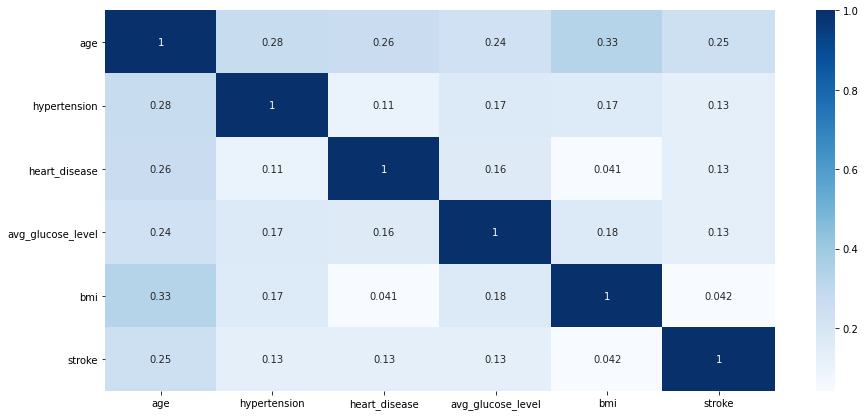

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),cmap='Blues',annot=True)
plt.show()

Verilerimizi numeric verilere dönüştürüyoruz.

In [ ]:
df = df.replace({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0 ,'Urban': 1, 'Rural': 0})

Makine öğrenimi algoritmaları kategorik değişkenleri işleyemez ve kötü sonuçlar verebilir. Bu durumda, etiket sütunumuzu ayrı 0 ve 1 sütunlarına dönüştürmemiz gerekir. Aşağıda kategorik sütunlarımızı (etiket sütunu) gösterge sütunlarına (0'lar ve 1'ler sütunları) dönüştürüyoruz. Bunun için get_dummies işlevini kullanıyoruz.

In [ ]:
object_col = [col for col in df.columns if df[col].dtype == 'object']

In [ ]:
df = pd.get_dummies(data=df, columns=object_col,drop_first=True)

Veri kümemizin dönüştürme sonrası özellik türleri.

In [ ]:
df.dtypes

gender                              int64
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int64
Residence_type                      int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Never_worked              uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
dtype: object

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,NaN,1,0,0,1,0,0,1,0
2,0,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0
3,1,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0,0,0,1
4,1,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,1,0


Veri kümesinin herhangi bir özelliğinin eksik değerler içerip içermediğini kontrol edelim. Varsa bu eksik değerleri doldurmak için knn inputer kullanacağız.

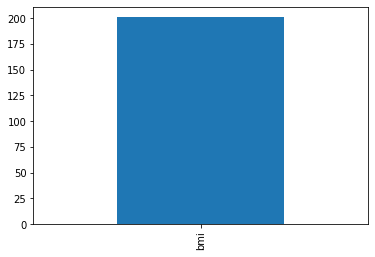

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum().plot.bar();

**KNN Inputer:** K-En Yakın Komşuları kullanarak eksik değerleri tamamlama iddiası. Her numunenin eksik değerleri, eğitim setinde bulunan n_neighbors en yakın komşulardan gelen ortalama değer kullanılarak hesaplanır. Eksik olmayan özellikler birbirine yakınsa iki örnek yakındır.

İşlem hattında RandomForestClassifier'ı kullandık çünkü eğittiğimiz önceki modeller RandomForestClassifier ile daha doğruydu.

Aşağıdaki grafiğe bakarak en iyi n_neighbours parametresini bulabiliriz. Bu değeri knnImputer için kullanacağız.

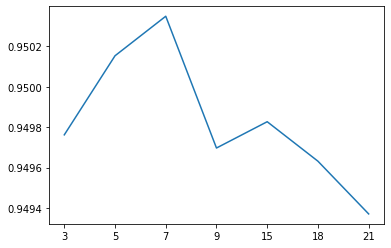

In [ ]:
results = list()
strategies = [str(i) for i in [3,5,7,9,15,18,21]]
for s in strategies:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, df[df.columns.difference(['stroke'])], df['stroke'], scoring='accuracy', cv=cv, n_jobs=-1)
    # store results
    results.append(np.mean(scores))
# plot model performance for comparison
plt.plot(strategies,results)
plt.show()

In [ ]:
imputer = KNNImputer(n_neighbors=int(strategies[results.index(max(results))]))
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

Boş sütunları doldurduktan sonra herhangi bir alanın hala boş olup olmadığını kontrol edelim.

In [ ]:
df.isna().values.any()

False

Veri kümesi bmi ve avg_glucose_level özelliklerinin aykırı değerlere sahip olduğundan daha önce bahsetmiştik. Veri kümesinde aykırı değerlere sahip olmak, algoritmayı yanlış tahminler yapmaya yönlendirir, bu tahmin modeli için doğru gibi görünür. Bu nedenle, aykırı değerleri grafik bir yöntem kullanarak eledik.

In [ ]:
print("BMI sütunundaki aykırı değerleri kaldırmadan önceki datanın şekli : ",df.shape)


BMI sütunundaki aykırı değerleri kaldırmadan önceki datanın şekli :  (5109, 16)


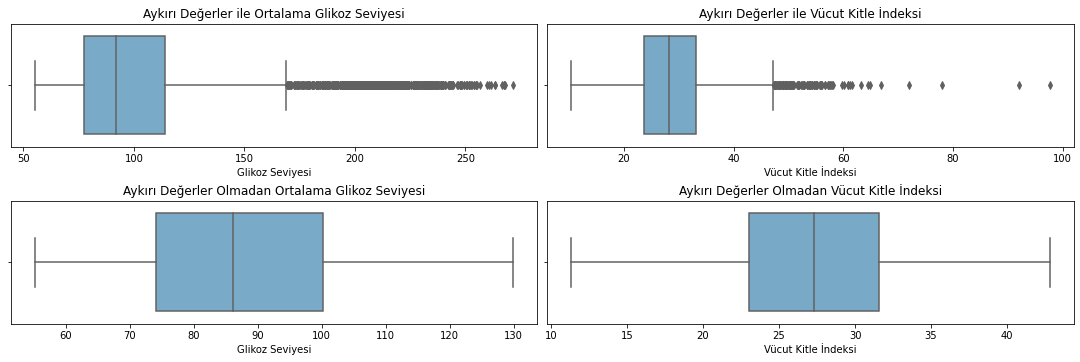

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(2,2,1)
plt.title("Aykırı Değerler ile Ortalama Glikoz Seviyesi")
sns.boxplot(x = df['avg_glucose_level'],palette = "Blues_r")
plt.xlabel("Glikoz Seviyesi")

plt.subplot(2,2,2)
plt.title("Aykırı Değerler ile Vücut Kitle İndeksi")
sns.boxplot(x = df['bmi'],palette = "Blues")
plt.xlabel("Vücut Kitle İndeksi")

plt.subplot(2,2,3)
plt.title("Aykırı Değerler Olmadan Ortalama Glikoz Seviyesi")
df = df[df['avg_glucose_level'] < 130] 
sns.boxplot(x = df['avg_glucose_level'],palette = "Blues_r")
plt.xlabel("Glikoz Seviyesi")

plt.subplot(2,2,4)
plt.title("Aykırı Değerler Olmadan Vücut Kitle İndeksi")
df = df[(df['bmi'] > 10.3) & (df['bmi'] < 43)]
sns.boxplot(x = df['bmi'],palette = "Blues")
plt.xlabel("Vücut Kitle İndeksi")

plt.tight_layout(pad=0.6)

In [ ]:
print("BMI sütunundaki aykırı değerleri kaldırdıktan sonra datanın şekli : ",df.shape)

BMI sütunundaki aykırı değerleri kaldırdıktan sonra datanın şekli :  (4022, 16)


Bmi ve avg_glucose_level endeksinin aykırı değerleri kaldırıldı. Hala aykırı değer içerip içermediklerini görmek için dağılımın grafiğini çizelim.

[Text(0, 0.5, 'Miktar'), Text(0.5, 0, 'Ortalama Glikoz Seviyesi')]

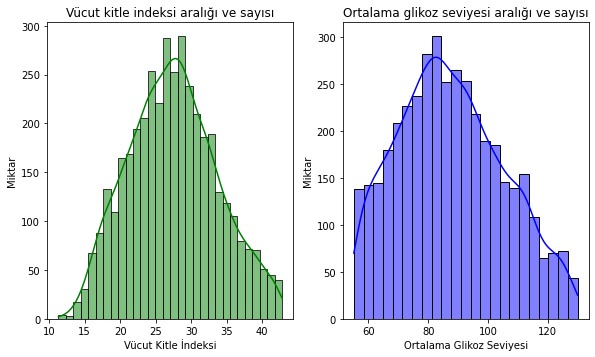

In [ ]:
plt.figure(figsize=(15,12))

plt.subplot(2,3,1)
ax = sns.histplot(df['bmi'], color = 'green', kde = True)
ax.set_title('Vücut kitle indeksi aralığı ve sayısı')
ax.set(xlabel='Vücut Kitle İndeksi', ylabel='Miktar')

plt.subplot(2,3,2)
ax2 = sns.histplot(df['avg_glucose_level'], kde = True, color = 'blue')
ax2.set_title('Ortalama glikoz seviyesi aralığı ve sayısı')
ax2.set(xlabel='Ortalama Glikoz Seviyesi', ylabel='Miktar')

Sınıflandırma için kullanılan makine öğrenim algoritmalarının çoğu, her sınıf için eşit sayıda örnek varsayımı etrafında tasarlandığından, dengesiz sınıflandırmalar tahmine dayalı modelleme için zorluk teşkil ettiğinden, herhangi bir sınıflandırıcı algoritmasını uygulamadan önce veri kümesi üzerinde denge kurmalıyız. Bu, özellikle azınlık sınıfı için zayıf öngörü performansına sahip modellerle sonuçlanır.

Verilerimiz oldukça dengesiz olduğundan, bununla başa çıkmanın iki yolu vardır. Ya çoğunluk sınıfının altını örnekleyebiliriz ya da azınlık sınıfını aşırı örnekleyebiliriz. Bu proje için yüksek hızda örnekleme tekniğini kullanacağız.

En basit yaklaşım, azınlık sınıfında örneklerin çoğaltılmasını içerir, ancak bu örnekler modele herhangi bir yeni bilgi eklememektedir. Bunun yerine, mevcut örneklerden yeni örnekler sentezlenebilir. Bu, azınlık sınıfı için bir veri artırma türüdür ve Sentetik Azınlık Aşırı Örnekleme Tekniği veya kısaca **SMOTE** olarak adlandırılır.

In [ ]:
sm = SMOTE(random_state=777, ratio = 1)
X, Y = sm.fit_sample(df[df.columns.difference(['stroke'])], df['stroke'])

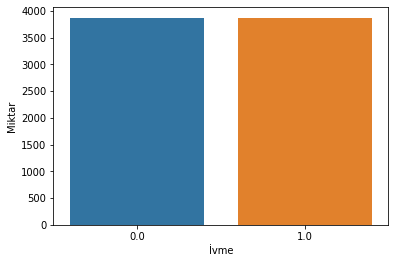

In [ ]:
y = pd.DataFrame({'stroke':Y})
ax = sns.countplot(data = y, x = 'stroke', y= None)
ax.set(xlabel='İvme', ylabel='Miktar')
plt.show()

## Modelleme <a class="anchor" id="classificationmodel"></a>

Bir **pipeline**, verilerin dönüştürüldüğü bir dizi adımdır.
Ardışık düzenler, tüm ön işleme adımlarını, özellik seçimlerini, ölçeklendirmeyi, özelliklerin kodlanmasını kapsüllememize olanak tanır ve en önemlisi veri sızıntısını önlememize yardımcı olur.

Aşağıda, en doğru sınıflandırma algoritmasını bulmak için cross validation ve pipeline tekniğini kullandık.

In [ ]:
DT_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',DecisionTreeClassifier(random_state=42))])
RF_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',RandomForestClassifier(random_state=42))])
SVM_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',SVC(random_state=42))])
LR_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',LogisticRegression(random_state=42))])

In [ ]:
DT_CROSS_VAL = cross_val_score(DT_PIPE,X,Y,cv=10)
RF_CROSS_VAL = cross_val_score(RF_PIPE,X,Y,cv=10)
SVM_CROSS_VAL = cross_val_score(SVM_PIPE,X,Y,cv=10)
LR_CROSS_VAL = cross_val_score(LR_PIPE,X,Y,cv=10)

In [ ]:
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,subplot_titles=('Decision Tree Cross Val Skorları',
                                                                     'RandomForest Cross Val Skorları',
                                                                    'SVM Cross Val Skorları','Logistic Regression Cross Val Skorları'))

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=RF_CROSS_VAL,name='RandomForest'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=SVM_CROSS_VAL,name='SVM'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=LR_CROSS_VAL,name='Logistic Regression'),
    row=4, col=1
)

fig.update_layout(height=700, width=1300, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="Skor")
fig.update_xaxes(title_text="Fold #")

fig.show()

Sınıflandırma için Random Forest'ı kullandık çünkü yukarıdaki grafiklerde gözlemlediğimiz çapraz doğrulama puanlarına göre diğer algoritmalardan daha kararlı ve daha doğru. Bu şekilde rastgele orman sınıflandırması, diğer sınıflandırma modellerinden daha doğru ve güvenilir bir model verir.

Veri setini% 70 tren seti ve% 30 test setine böldük.

**random_state:** Bölmeyi uygulamadan önce verilere uygulanan karıştırmayı kontrol eder. Birden çok işlev çağrısında yeniden üretilebilir çıktı için bir int iletin.

**stratify:** Veri kümesini eğitime ve test kümelerine, her bir sınıfta orijinal veri kümesinde gözlemlendiği gibi aynı oranlarda örnekleri koruyacak şekilde bölmek için aşamalı tren-test ayırma kullandık.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.3,random_state=1,stratify=Y, shuffle=True)

**Min-Max Normalizasyon:** Her unsuru belirli bir aralığa ölçeklendirerek unsurları dönüştürün. Bu tahmin aracı, eğitim setinde verilen aralıkta olacak şekilde her özelliği ayrı ayrı ölçeklendirir ve çevirir, ör. sıfır ile bir arasında.

Makine öğrenimi modelini eğitmeden önce önce **Min-Max Normalizasyon** tekniğini kullanıyoruz.

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Overfitting'i önlemek için **cross_val_score** değerini değerlendirin. Bu skkora bakarak, train ve test bölme dağılımımızın iyi olduğunu söyleyebiliriz.

**cv**: Çapraz doğrulama ayırma stratejisini belirler. 5 kullandık, yani 5 kat ile (Tabakalı) KFold kullanacak demektir.

In [ ]:
cv = RandomForestClassifier()
accuracies = cross_val_score(estimator = cv, X = x_train, y= y_train, cv = 5)
print("Ortalama Doğruluk: ",np.mean(accuracies))
print("Ortalama Standart Sapma: ",np.std(accuracies))

Ortalama Doğruluk:  0.9773154556430356
Ortalama Standart Sapma:  0.004792232266664134


Kullandığımız Random forest model parametreleri:

**n_estimators**: Tree'deki ağaç sayısı.

**max_features**: En iyi bölünmeyi ararken göz önünde bulundurulması gereken özelliklerin sayısı.

**max_depth**: Ağacın maksimum derinliği. Yok ise, düğümler tüm yapraklar saf olana kadar veya tüm yapraklar min_samples_split'den daha az örnek içerene kadar genişletilir.

**GridSearchCV**: Bir tahminci için belirtilen parametre değerleri üzerinde kapsamlı arama.

In [ ]:
# Number of trees in random forest
n_estimators = [100, 200, 300, 500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None, 10, 80, 90, 100, 110]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, random_grid, cv = 5)
rf_cv.fit(x_train, y_train)

print("Hyperparametreler: ",rf_cv.best_params_)
print("En iyi doğruluk:  ",rf_cv.best_score_)

Hyperparametreler:  {'max_depth': 110, 'max_features': 'sqrt', 'n_estimators': 100}
En iyi doğruluk:   0.9795287975921234


Modeli GridSearchCV kullanarak bulduğumuz en iyi parametrelerle eğitelim.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=rf_cv.best_params_["n_estimators"],
    max_depth=rf_cv.best_params_["max_depth"],
    max_features=rf_cv.best_params_["max_features"]
)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Değerlendirme<a class="anchor" id="evaluation"></a>

İstatistikte, R ^ 2 olarak gösterilen belirleme katsayısı, bağımsız değişken (ler) den öngörülebilir olan bağımlı değişkendeki varyansın oranıdır.

Modelimizin R^2 skoru

In [ ]:
rf.score(x_test,y_test)

0.9759036144578314

Modelimizin r ^ 2 puanına baktığımızda modelimizin iyi bir doğruluğa sahip olduğunu söyleyebiliriz. Çünkü 1'e çok yakın.

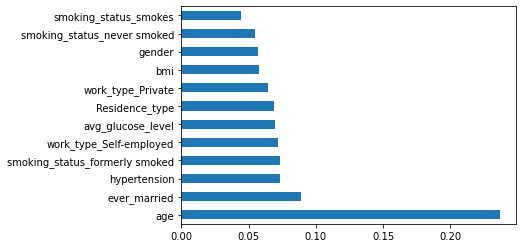

In [ ]:
importances = pd.Series(rf.feature_importances_, index=df[df.columns.difference(['stroke'])].columns)
importances.nlargest(12).plot(kind='barh');

Yukarıdaki grafiğe bakarak **age** özelliğinin inme geçirip geçirmeme konusunda diğer özelliklerden önemli ölçüde daha fazla etkiye sahip olduğunu söyleyebiliriz.

### Confusion matrix

**confusion_matrix**: Bir sınıflandırmanın doğruluğunu değerlendirmek için confusion matrix hesaplayın. Satırlar, tahmin edilen değerlerdir sütunlar, bu bilgileri kullanarak modelimizi yorumlayabilir hangi veriyi hangi miktarda yanlış tahmin ettiğimizi inceleyebiliriz.



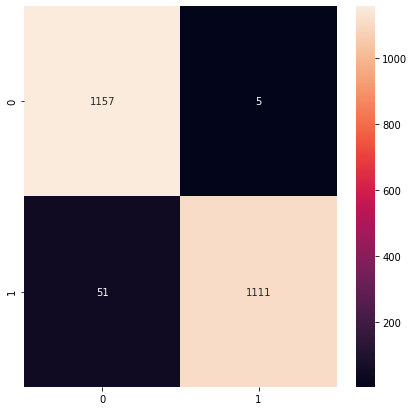

In [ ]:
x_pred_test = rf.predict(x_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, x_pred_test), index = [i for i in ['0','1']],
                  columns = [i for i in ['0', '1']])
plt.figure(figsize = (7,7))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d");

Modelimizin kafa confusion matrix'ine bakarak, modelimiz felç geçirmeyen 3 kişi için felç olduğunu söylerken, felç geçiren 52 kişiyi felç geçirmemiş olarak göstermiştir.

### Classification report

**classification_report :** classification_report görselleştiricisi, model için precision, recall, F1 ve support scores görüntüler.

**True Positives (TP):** Bunlar doğru tahmin edilen pozitif değerlerdir, bu da gerçek sınıfın değerinin evet olduğu ve öngörülen sınıfın değerinin de evet olduğu anlamına gelir.

**True Negatives (TN):** Bunlar doğru tahmin edilen negatif değerlerdir, bu da gerçek sınıfın değerinin hayır olduğu ve öngörülen sınıfın değerinin de hayır olduğu anlamına gelir. 

**False Positives (FP):** Gerçek sınıf hayır olduğunda ve öngörülen sınıf evet olduğunda.

**False Negatives (FN):** Gerçek sınıf evet olduğunda, ancak hayır olarak öngörülen sınıf olduğunda.

**Recall**, "Tahminlerimizin yüzde kaçı doğruydu" anlamına gelir. Recall, bir sınıflandırıcının tüm pozitif örnekleri bulma yeteneğidir Recall= TP / (TP + FN)

**Precision**, "Olumlu vakaların yüzde kaçını yakaladık" olacaktır. precision, bir sınıflandırıcının aslında negatif olan bir örneği pozitif olarak etiketlememe yeteneğidir Precision= TP / (TP + FP)

**F1-score**, "Olumlu tahminlerimizin yüzde kaçı doğruydu" anlamına gelir. F1-score, en iyi skor 1.0 ve en kötüsü 0.0 F1 Skoru = 2 * (Recall * Precision) / (Recall + Precision) olacak şekilde, hassasiyet ve geri çağırmanın ağırlıklı harmonik ortalamasıdır

**Support**, belirli bir sınıfın veri kümenizdeki oluşum sayısıdır.

Macro-average precision ve recall puanı, ayrı sınıfların precision ve recall  puanlarının aritmetik ortalaması olarak hesaplanır.

Macro-average F1-score, bireysel sınıfların F1-score aritmetik ortalaması olarak hesaplanır.

In [ ]:
print(classification_report(y_test, x_pred_test, target_names=["Stroke Negatif", "Stroke Positif"]))

                precision    recall  f1-score   support

Stroke Negatif       0.96      1.00      0.98      1162
Stroke Positif       1.00      0.96      0.98      1162

      accuracy                           0.98      2324
     macro avg       0.98      0.98      0.98      2324
  weighted avg       0.98      0.98      0.98      2324



Sınıflandırma raporumuza bakarak, precision, recall ve f1-score inme olup olmaması açısından çok yakın değerler çıkardığını söyleyebiliriz.

### ROC Eğrisi

AUC-ROC eğrisi, iki-çok sınıflı sınıflandırma problemi için model seçim ölçüsüdür. ROC, farklı sınıflar için bir olasılık eğrisidir. ROC, tahmin edilen olasılık açısından verilen sınıfları ayırt etmede modelin ne kadar iyi olduğunu söyler.

Tipik bir ROC eğrisinde X ekseninde False Positive Rate (FPR) ve Y ekseninde True Positive Rate (TPR) bulunur.

AUC (Eğri altındaki alan) ne kadar yüksekse, modelin pozitif ve negatif sınıfları ayırt etme performansı o kadar iyidir.

AUC = 1 olduğunda, sınıflandırıcı tüm Pozitif ve Negatif sınıf noktalarını doğru bir şekilde ayırt edebilir. Bununla birlikte, AUC 0 olsaydı, sınıflandırıcı tüm Negatifleri Pozitif olarak ve tüm Pozitifleri Negatif olarak tahmin ederdi.

Aşağıdaki grafikten de görebileceğimiz gibi, sonuç olarak iki sınıf arasında net bir ayrım var, yani  AUC 1'e sahibiz. ROC eğrisi ile taban çizgisi arasındaki maksimum alan burada elde edilir.

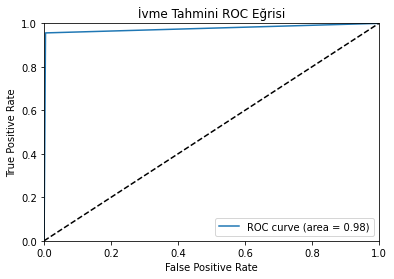

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, x_pred_test)
roc_auc = auc(fpr, tpr)
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('İvme Tahmini ROC Eğrisi')
pl.legend(loc="lower right")
pl.show()

ROC için AUC, roc_auc_score () işlevi kullanılarak da hesaplanabilir. AUC değeri, 0,5 ile 1 arasındadır; burada 0,5, kötü bir sınıflandırıcıyı ve 1, mükemmel bir sınıflandırıcıyı belirtir. Elde ettiğimiz sonuç bize gösteriyor ki, bizim oluşturduğumuz sınıflandırıcı neredeyse mükemmel.

In [ ]:
roc_auc_score(y_test, x_pred_test)

0.9759036144578312

## Referanslar<a class="anchor" id="references"></a>

[1] https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

[2] https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

[4] https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

[5] https://scikit-learn.org/0.17/modules/generated/sklearn.metrics.r2_score.html

[6] https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/

[7] https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

[8] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[9] https://towardsdatascience.com/clustering-why-to-use-it-16d8e2fbafe#:~:text=Inertia%20is%20the%20sum%20of,how%20dense%20the%20clusters%20are

[10] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

[11] https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

[12] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

[13] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[14] https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

[15] https://www.kaggle.com/aditimulye/stroke-prediction-visualization-prediction

[16] https://www.kaggle.com/bariscal/stroke-entirely-ml-project-and-eda

[17] https://www.kaggle.com/ivangavrilove88/stroke-fe-smote-technique-17-models

[18] https://www.kaggle.com/jabeen12-stroke-prediction-data-visualization

[19] https://www.kaggle.com/ginelledsouza/stroke-analysis

[20] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

[21] https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

[22] https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

[23] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html




**Disclaimer!** <font color='grey'>This notebook was prepared by Mehmet Sezer, Burak Yılmaz as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>